# Identifying transiting exoplanet signals in a light curve

In [1]:
import lightkurve as lk
%matplotlib inline

---

## 1. Downloading a Light Curve and Removing Long-Term Trends

As an example, we will download all available [*Kepler*](https://archive.stsci.edu/kepler) observations for a known multi-planet system, [Kepler-69](https://iopscience.iop.org/article/10.1088/0004-637X/768/2/101).

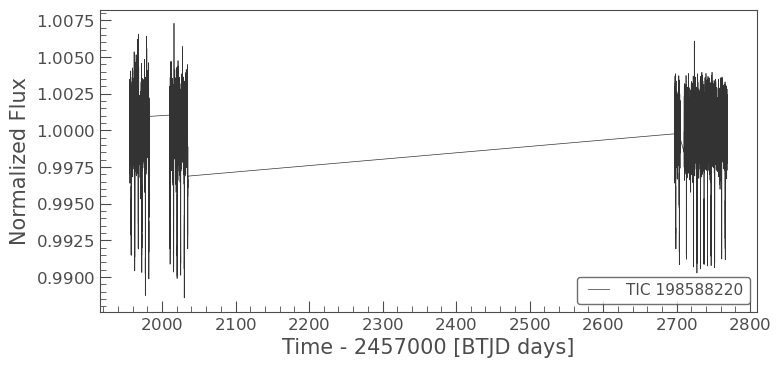

In [2]:
sr = lk.search_lightcurve('HAT-P-67', author='SPOC')
lcs = sr.download_all()
lc = lcs.stitch().normalize().remove_nans()
lc.plot();

In [3]:
lc_flat = lc.flatten(window_length=901)

(2732.0, 2742.0)

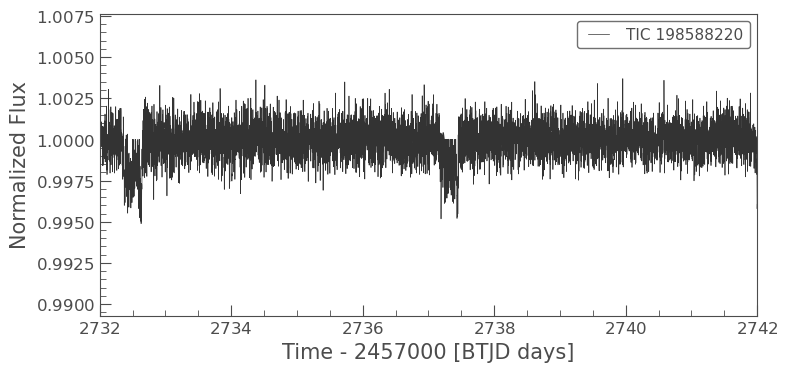

In [4]:
ax = lc_flat.plot()
ax.set_xlim(2732, 2742)

## 2. The Box Least Squares Method for Finding Transiting Planets

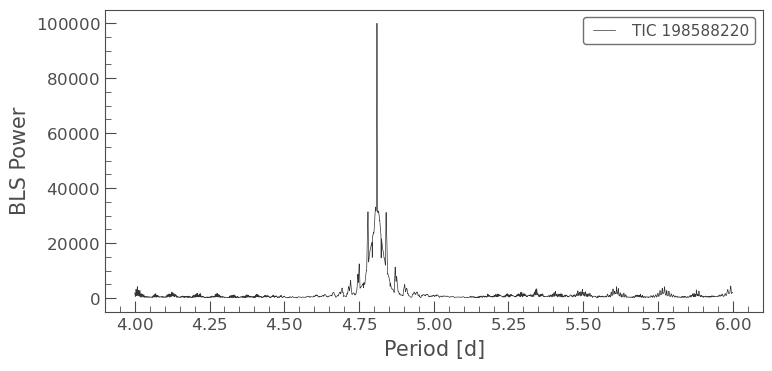

In [5]:
import numpy as np
# Create array of periods to search
period = np.linspace(4, 6, 10000)
# Create a BLSPeriodogram
bls = lc.to_periodogram(method='bls', period=period, frequency_factor=500);
bls.plot();

In [6]:
planet_b_period = bls.period_at_max_power
planet_b_t0 = bls.transit_time_at_max_power
planet_b_dur = bls.duration_at_max_power

# Check the value for period
planet_b_period

<Quantity 4.81008101 d>

To confirm that this period and transit time (epoch) correspond to a transit signal, we can phase-fold the light curve using these values and plot it.

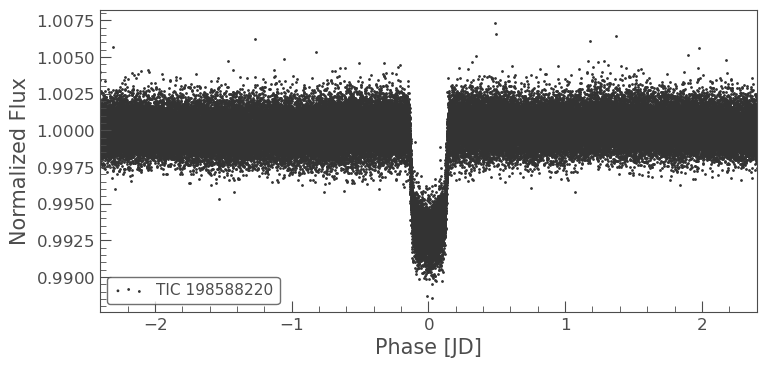

In [7]:
ax = lc.fold(period=planet_b_period, epoch_time=planet_b_t0).scatter()
ax.set_xlim(-planet_b_period.value/2, planet_b_period.value/2);

## 4. Retrieving a Transit Model and Cadence Mask

The BLS periodogram has features that make it possible to search for multiple planets in the same system. If we want to identify additional transit signals, it will be much more convenient if we first remove the previously identified signal. This will prevent the high-power periodicity of the first planet, planet b, from dominating the BLS periodogram, and will allow us to find lower signal-to-noise ratio (SNR) transits.

We can create a cadence mask for the light curve using the transit parameters from the `BoxLeastSquaresPeriodogram`.

In [8]:
# Create a cadence mask using the BLS parameters
planet_b_mask = bls.get_transit_mask(period=planet_b_period, 
                                     transit_time=planet_b_t0, 
                                     duration=planet_b_dur*1.1)

Now, we can create a masked version of the light curve to search for additional transit signals. The light curve is shown below, with masked cadences marked in red.

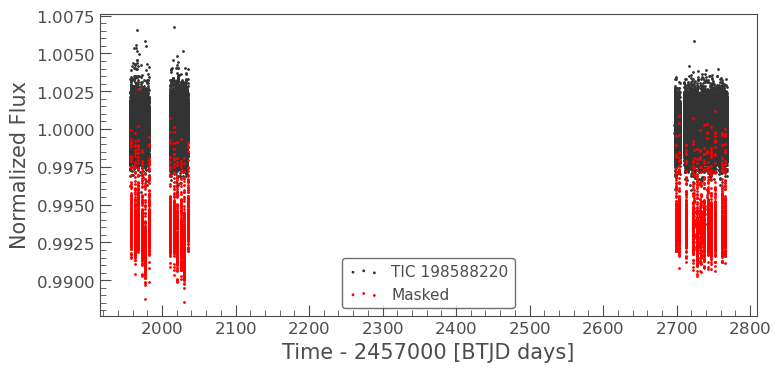

In [9]:
masked_lc = lc[~planet_b_mask].flatten(window_length=1801)
ax = masked_lc.scatter();
lc[planet_b_mask].scatter(ax=ax, c='r', label='Masked');

We can also create a BLS model to visualize the transit fit. This returns a `LightCurve` object with the BLS model in the flux column.

In [10]:
# Create a BLS model using the BLS parameters
planet_b_model = bls.get_transit_model(period=planet_b_period, 
                                       transit_time=planet_b_t0, 
                                       duration=planet_b_dur*1.1)

We can plot this over the folded light curve to confirm that it accurately represents the transit.

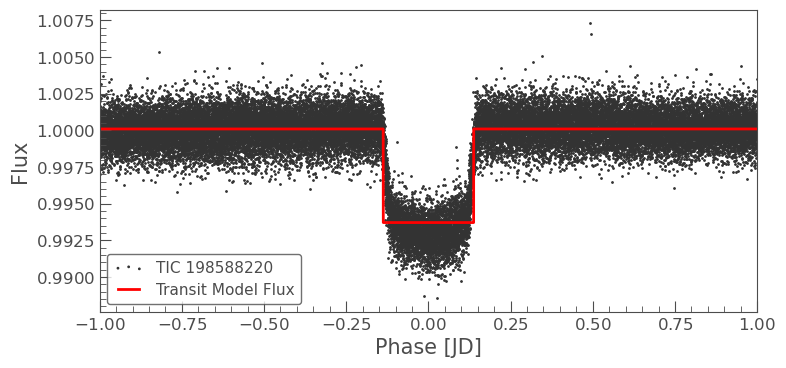

In [11]:
ax = lc.fold(planet_b_period, planet_b_t0).scatter()
planet_b_model.fold(planet_b_period, planet_b_t0).plot(ax=ax, c='r', lw=2)
ax.set_xlim(-1, 1);

In [13]:
import matplotlib.pyplot as plt

In [15]:
%config InlineBackend.figure_format='retina'

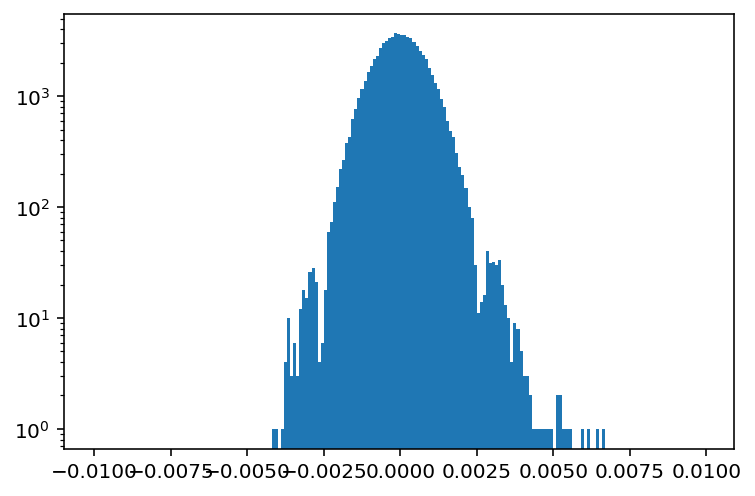

In [24]:
lc_flat = masked_lc.flatten(window_length=15)

resid = lc_flat.flux.value-1

plt.hist(resid, bins=np.arange(-0.01, 0.01, 0.0001))
plt.yscale('log')

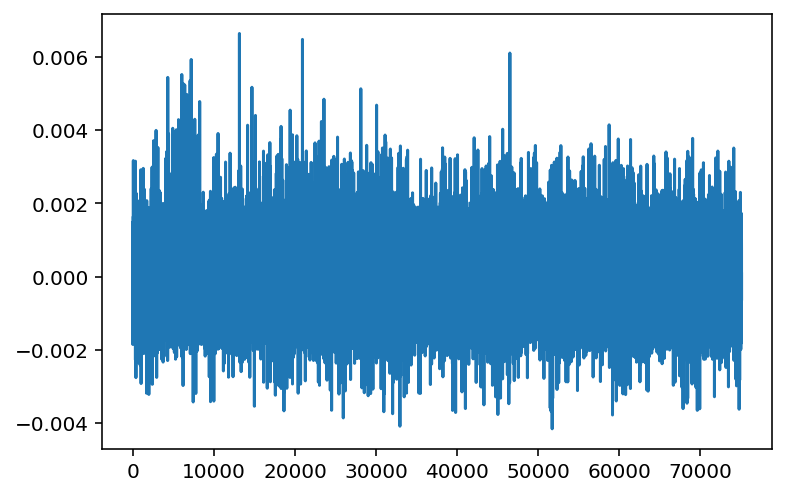

In [25]:
plt.plot(resid)

In [26]:
np.std(resid)

MaskedNDArray(0.00084906)

## 5. Identifying Additional Transiting Planet Signals in the Same Light Curve

Now that we have created a light curve with the first identified planet masked out, we can search the remaining light curve for additional transit signals. Here, we search for long-period planets by increasing our range of periods to 1–300 days.

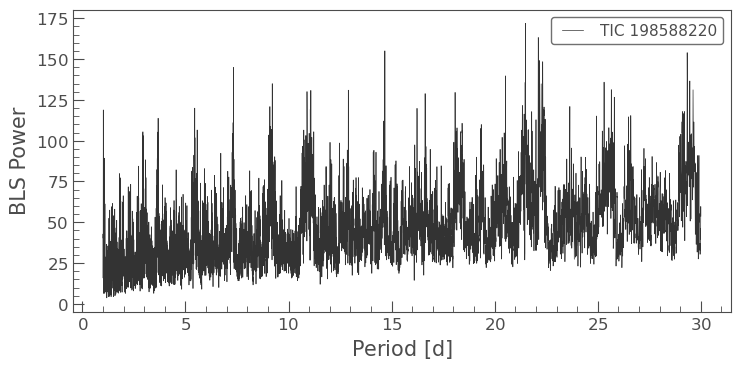

In [78]:
period = np.linspace(1, 30, 10000)
bls = masked_lc.to_periodogram('bls', period=period, frequency_factor=500)
bls.plot();

In [79]:
planet_c_period = bls.period_at_max_power
planet_c_t0 = bls.transit_time_at_max_power
planet_c_dur = bls.duration_at_max_power

# Check the value for period
planet_c_period

<Quantity 21.49344934 d>

We can again plot the phase-folded light curve to examine the transit.

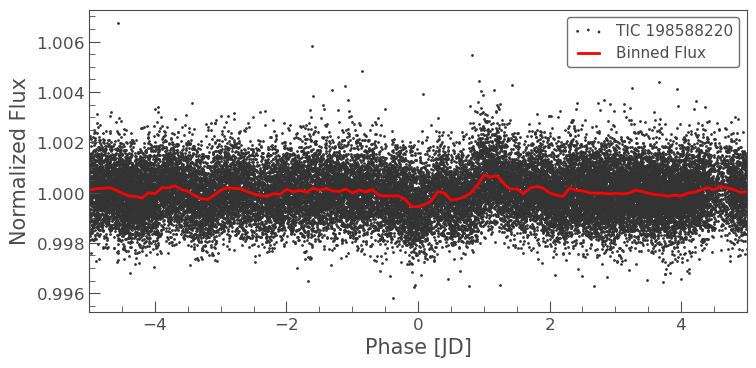

In [80]:
ax = masked_lc.fold(planet_c_period, planet_c_t0).scatter()
masked_lc.fold(planet_c_period, planet_c_t0).bin(.1).plot(ax=ax, c='r', lw=2, 
                                                          label='Binned Flux')
ax.set_xlim(-5, 5);

This signal is lower SNR because there are fewer transits due to the longer period, and the shallower depth implies that the planet is smaller. To help see the transit more clearly, we have overplotted the binned flux, combining consecutive points taken over a span of 0.1 days.

We have now successfully identified two planets in the same system! We can use the BLS models to visualize the transit timing in the light curve.

In [81]:
planet_c_model = bls.get_transit_model(period=planet_c_period, 
                                       transit_time=planet_c_t0, 
                                       duration=planet_c_dur)

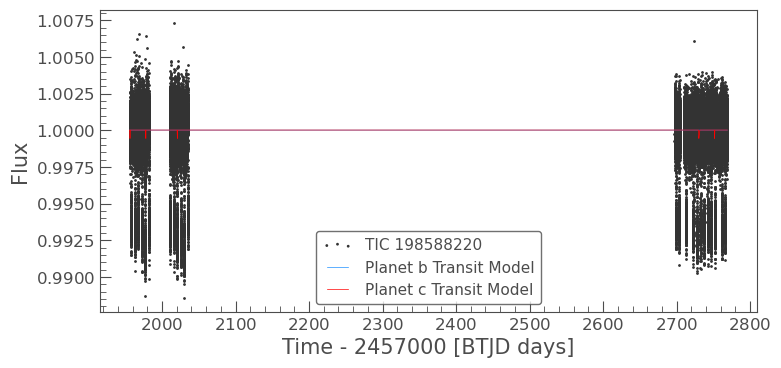

In [82]:
ax = lc.scatter();
planet_b_model.plot(ax=ax, c='dodgerblue', label='Planet b Transit Model');
planet_c_model.plot(ax=ax, c='r', label='Planet c Transit Model');

(2015.0, 2025.0)

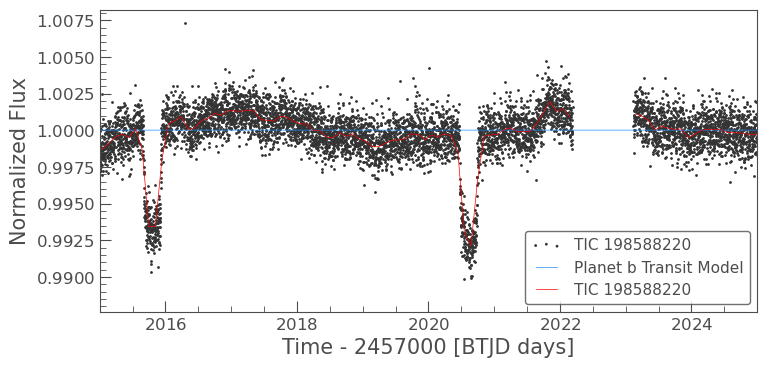

In [89]:
ax = lc.scatter();
planet_b_model.plot(ax=ax, c='dodgerblue', label='Planet b Transit Model');
#planet_c_model.plot(ax=ax, c='r', label='Planet c Transit Model');
lc.bin(0.1).plot(ax=ax, color='r', lw=2);
ax.set_xlim(2015, 2025)

## 6. Using the Interactive BLS Periodogram in Lightkurve

Lightkurve also has a tool that enables you to interactively perform a BLS search. A quick demo of this feature is shown below. 

To use the [LightCurve.interact_bls()](https://docs.lightkurve.org/reference/api/lightkurve.LightCurve.interact_bls.html?highlight=lightcurve%20interact_bls#lightkurve.LightCurve.interact_bls) method, zoom in on peaks in the BLS periodogram using the interactive plotting tools. To improve the fit, you can change the transit duration. The phase-folded light curve panel in the top right and the full light curve below it will automatically update to plot the highest power BLS model. The BLS parameters with highest power are noted in the bottom right of the figure.

![interact_bls() demo animation](../1-getting-started/interact-screenshots/interact_bls.gif)

## About this Notebook

**Authors:** Nicholas Saunders (nksaun@hawaii.edu)

**Updated On:** 2020-09-28

## Citing Lightkurve and Astropy

If you use `lightkurve` or its dependencies in your published research, please cite the authors. Click the buttons below to copy BibTeX entries to your clipboard.

In [17]:
lk.show_citation_instructions()

<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>
